In [6]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import random

import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import re

# MISSINGNO
import missingno as msno

from datetime import date



In [7]:
# MATPLOTLIB
import matplotlib.pyplot as plt

#PLOTLY EXPRESS
import plotly.express as px
import plotly.graph_objects as go

# SEABORN
import seaborn as sns


In [8]:
def random_delay():
    time.sleep(random.uniform(2, 15))

### 1. Procèdure :

1. Aller sur la page de résultats avec selenium
2. Récupérer les URL pour aller de page en page
3. Faire une fonction pour aller récupérer les URL de chaque annonce sur chaque page
4. Couper les URL en relatif puis les reconcatener pour les passer dans l'API
5. Itérer pour requêter l'API avec chaque URL récupérée sur chaque page de résultats

1.1 Je teste sur la première page

In [9]:
## 1. je lance selenium pour aller sur la page de résultats ########################################################################
service = Service(executable_path = 'chromedriver.exe')                         # je dis où est mon driver                       
driver = webdriver.Chrome(service=service)                                      # je définis mon driver
driver.get("https://www.welcometothejungle.com/fr")                             # et je l'envoie sur la page d'accueil

wait = WebDriverWait(driver, 8)

input_element = driver.find_element(By.ID,"search-query-field")                 # je sélectionne la barre de recherche
input_element.clear()                                                           # je la vide au cas où elle est pré-remplie                                             
input_element.send_keys("Data analyst" + Keys.ENTER)                            # j'écris dans la barre de recherche

random_delay()                                                     # je mets un petit delay aléatoire 
                                                                   # pour laisser le temps à la page de charger

## 2. je vais chercher les url des annonces ########################################################################################
## je print un peu tout pour vérifier

links = (driver.find_elements(By.PARTIAL_LINK_TEXT, "Data")        # avec Selenium, je cherche les liens avec data dedans quelque soit la casse 
        or driver.find_elements(By.PARTIAL_LINK_TEXT, "DATA")
        or  driver.find_elements(By.PARTIAL_LINK_TEXT, "data")) 

urls = [link.get_attribute("href") for link in links]              # j'extraits le contenu de href pour le mettre dans la liste urls
      
print(f"J'ai {len(urls)} annonces")
print(urls)

## 3. je vais chercher les url de pagination ######################################################################################
## je print un peu tout pour vérifier

page_source = driver.page_source                                   # je vais chercher la page avec mon driver
soup = BeautifulSoup(page_source, "html.parser")                   #  je passe le code HTML à BeautifulSoup pour l'analyser

soup_pages = soup.find('nav', {"aria-label" : "Pagination"})      # Puis je vais chercher la section nav :

if soup_pages is not None:                                        # Je mets un if si la page n'est pas chargée et que nav est vide
    pli = soup_pages.find_all('li')                               # Puis je vais chercher tous les li contenus dans cette nav
    nb_pages = pli[-2].text                                       # Puis je vais chercher le texte de l'avant dernier li 
    print(f"\nJ'ai {nb_pages} pages")                               # (car le dernier c'est la flèche) pour avoir le nombre de pages                                         

else:                                                             # si la page n'a pas eu le temps de charger, j'affiche un message
    print("Aucun élément HTML correspondant au sélecteur spécifié n'a été trouvé.")


result_url = driver.current_url                                   # je récupère l'URL sur laquelle je suis
print("\nThe current url is: "+str(result_url))
base_url = result_url.replace("1","")

driver.quit()                                                     # je ferme le navigateur une fois tout fini


ElementNotInteractableException: Message: element not interactable
  (Session info: chrome=126.0.6478.115)
Stacktrace:
	GetHandleVerifier [0x00007FF7D5D81F52+60322]
	(No symbol) [0x00007FF7D5CFCEC9]
	(No symbol) [0x00007FF7D5BB7CE9]
	(No symbol) [0x00007FF7D5C01093]
	(No symbol) [0x00007FF7D5BFF20B]
	(No symbol) [0x00007FF7D5C2C21A]
	(No symbol) [0x00007FF7D5BFADB6]
	(No symbol) [0x00007FF7D5C2C430]
	(No symbol) [0x00007FF7D5C4BC80]
	(No symbol) [0x00007FF7D5C2BFC3]
	(No symbol) [0x00007FF7D5BF9617]
	(No symbol) [0x00007FF7D5BFA211]
	GetHandleVerifier [0x00007FF7D60994AD+3301629]
	GetHandleVerifier [0x00007FF7D60E36D3+3605283]
	GetHandleVerifier [0x00007FF7D60D9450+3563680]
	GetHandleVerifier [0x00007FF7D5E34326+790390]
	(No symbol) [0x00007FF7D5D0750F]
	(No symbol) [0x00007FF7D5D03404]
	(No symbol) [0x00007FF7D5D03592]
	(No symbol) [0x00007FF7D5CF2F9F]
	BaseThreadInitThunk [0x00007FFC996B257D+29]
	RtlUserThreadStart [0x00007FFC9B0CAF28+40]


Maintenant que j'ai le nombre de pages, je récupère les URL de toutes les pages de résultat

In [ ]:
base_url = "https://www.welcometothejungle.com/fr/jobs?query=data%20analyst&refinementList%5Boffices.country_code%5D%5B%5D=FR&refinementList%5Bcontract_type%5D%5B%5D=full_time&refinementList%5Bcontract_type%5D%5B%5D=temporary&page="
page_number = 1
urls_to_scrape = []

# je fais une boucle qui itère le nom de la page autant de fois que nécessaire (on aurait pu faire un while si on ne connaissait pas le nombre de page)
for i in range(1,int(nb_pages)):
  url = f"{base_url}{i}"
  urls_to_scrape.append(url)

print(urls_to_scrape)


['https://www.welcometothejungle.com/fr/jobs?query=data%20analyst&refinementList%5Boffices.country_code%5D%5B%5D=FR&refinementList%5Bcontract_type%5D%5B%5D=full_time&refinementList%5Bcontract_type%5D%5B%5D=temporary&page=1', 'https://www.welcometothejungle.com/fr/jobs?query=data%20analyst&refinementList%5Boffices.country_code%5D%5B%5D=FR&refinementList%5Bcontract_type%5D%5B%5D=full_time&refinementList%5Bcontract_type%5D%5B%5D=temporary&page=2', 'https://www.welcometothejungle.com/fr/jobs?query=data%20analyst&refinementList%5Boffices.country_code%5D%5B%5D=FR&refinementList%5Bcontract_type%5D%5B%5D=full_time&refinementList%5Bcontract_type%5D%5B%5D=temporary&page=3', 'https://www.welcometothejungle.com/fr/jobs?query=data%20analyst&refinementList%5Boffices.country_code%5D%5B%5D=FR&refinementList%5Bcontract_type%5D%5B%5D=full_time&refinementList%5Bcontract_type%5D%5B%5D=temporary&page=4', 'https://www.welcometothejungle.com/fr/jobs?query=data%20analyst&refinementList%5Boffices.country_code%

### 2. Après le test, je lance pour de bon cette 1e étape

Je commence par lancer le code pour récupérer les pages de résultats

In [11]:
############## SCRIPT PRINCIPAL COMPLET 1 ####################################
##############################################################################

## 1. je lance selenium pour aller sur la page de résultats ########################################################################
service = Service(executable_path = 'chromedriver.exe')                         # je dis où est mon driver                       
driver = webdriver.Chrome(service=service)                                      # je définis mon driver
driver.get("https://www.welcometothejungle.com/fr")                                                         # et je l'envoie sur la page d'accueil

wait = WebDriverWait(driver, 8)                                                 # je laisse le temps à la page de se charger

input_element = driver.find_element(By.ID,"search-query-field")                 # je sélectionne la barre de recherche
input_element.clear()                                                           # je la vide au cas où elle est pré-remplie                                             
input_element.send_keys("Data analyst" + Keys.ENTER)                            # j'écris dans la barre de recherche

random_delay()                                                                     # je laisse le temps à la page de charger

## 2. je vais chercher les url de pagination ######################################################################################
page_source = driver.page_source                                   # je vais chercher la page avec mon driver
soup = BeautifulSoup(page_source, "html.parser")                   #  je passe le code HTML à BeautifulSoup pour l'analyser

soup_pages = soup.find('nav', {"aria-label" : "Pagination"})      # Puis je vais chercher la section nav :

if soup_pages is not None:                                        # Je mets un if si la page n'est pas chargée et que nav est vide
    pli = soup_pages.find_all('li')                               # Puis je vais chercher tous les li contenus dans cette nav
    nb_pages = pli[-2].text                                       # Puis je vais chercher le texte de l'avant dernier li 
    print(f"\nJ'ai {nb_pages} pages")                               # (car le dernier c'est la flèche) pour avoir le nombre de pages

else:                                                             # si la page n'a pas eu le temps de charger, j'affiche un message
    print("Aucun élément HTML correspondant au sélecteur spécifié n'a été trouvé.")

result_url = driver.current_url                                   # je récupère l'URL sur laquelle je suis
base_url = result_url.replace("1","")

base_url = "https://www.welcometothejungle.com/fr/jobs?query=data%20analyst&refinementList%5Boffices.country_code%5D%5B%5D=FR&refinementList%5Bcontract_type%5D%5B%5D=full_time&refinementList%5Bcontract_type%5D%5B%5D=temporary&page="
page_number = 1
urls_to_scrape = []

# 3. je fais une boucle qui itère le nom de la page autant de fois que nécessaire
for i in range(1,int(nb_pages)):
    url = f"{base_url}{i}"
    urls_to_scrape.append(url)
print(urls_to_scrape)

random_delay()     

jobs_list = []

for each_page in urls_to_scrape:
    try:
    # je charge la page actuelle dans le navigateur Web
      driver.get(each_page)
      random_delay() 

     # j'attends que la page soit entièrement chargée
      wait = WebDriverWait(driver, 20)
      wait.until(EC.visibility_of_element_located((By.PARTIAL_LINK_TEXT, "Data")))

      links = (driver.find_elements(By.PARTIAL_LINK_TEXT, "Data")        # avec Selenium, je cherche les liens avec data dedans quelque soit la casse 
        or driver.find_elements(By.PARTIAL_LINK_TEXT, "DATA")
        or  driver.find_elements(By.PARTIAL_LINK_TEXT, "data"))

      urls = [link.get_attribute("href") for link in links]              # j'extraits le contenu de href pour le mettre dans la liste urls
      print(urls)
    
      jobs_list.extend(urls)
    except:
        print(f"An error occured on page {driver.current_url}")  

print(f"J'ai {len(jobs_list)} annonces au total")
print(jobs_list)

driver.quit()                                                     # je ferme le navigateur une fois tout fini



J'ai 34 pages
['https://www.welcometothejungle.com/fr/jobs?query=data%20analyst&refinementList%5Boffices.country_code%5D%5B%5D=FR&refinementList%5Bcontract_type%5D%5B%5D=full_time&refinementList%5Bcontract_type%5D%5B%5D=temporary&page=1', 'https://www.welcometothejungle.com/fr/jobs?query=data%20analyst&refinementList%5Boffices.country_code%5D%5B%5D=FR&refinementList%5Bcontract_type%5D%5B%5D=full_time&refinementList%5Bcontract_type%5D%5B%5D=temporary&page=2', 'https://www.welcometothejungle.com/fr/jobs?query=data%20analyst&refinementList%5Boffices.country_code%5D%5B%5D=FR&refinementList%5Bcontract_type%5D%5B%5D=full_time&refinementList%5Bcontract_type%5D%5B%5D=temporary&page=3', 'https://www.welcometothejungle.com/fr/jobs?query=data%20analyst&refinementList%5Boffices.country_code%5D%5B%5D=FR&refinementList%5Bcontract_type%5D%5B%5D=full_time&refinementList%5Bcontract_type%5D%5B%5D=temporary&page=4', 'https://www.welcometothejungle.com/fr/jobs?query=data%20analyst&refinementList%5Boffice

Maintenant je forme mes URL comme il faut pour les passer par l'API

In [14]:
relative_urls = [sub.replace("https://www.welcometothejungle.com/fr/companies", "") for sub in jobs_list]
print(relative_urls)
print(len(relative_urls))

['/alpagga-1/jobs/data-analyst_paris?q=ec6ef1d15bd95375a6c2c0cdf189bb06&o=205b35ca-40fb-4879-aac6-f5b859794d2e', '/avanade-france/jobs/business-analyst-data-h-f_issy-les-moulineaux_AF_Z0MgmWr?q=ec6ef1d15bd95375a6c2c0cdf189bb06&o=f9866298-9d38-49cd-a815-8549f762ea13', '/niji/jobs/consultant-data-analyst-f-h_issy-les-moulineaux_NIJI_x3oy1em?q=ec6ef1d15bd95375a6c2c0cdf189bb06&o=7b2ada66-75ad-4410-ae04-8d2bdc6bbd94', '/joko/jobs/data-analyst-product_paris?q=ec6ef1d15bd95375a6c2c0cdf189bb06&o=466a5934-e861-4438-9690-ef0d687fad12', '/cybelangel/jobs/senior-data-analyst_paris?q=ec6ef1d15bd95375a6c2c0cdf189bb06&o=2601ede9-9a00-488e-a373-e366750b4fda', '/niji/jobs/manager-data-analytics-f-h_issy-les-moulineaux?q=ec6ef1d15bd95375a6c2c0cdf189bb06&o=f1f52d64-b253-4d32-a01e-1185881a7c19', '/joko/jobs/data-analyst_paris?q=ec6ef1d15bd95375a6c2c0cdf189bb06&o=44526c19-4769-4cc7-a55f-2c9cda09f974', '/niji/jobs/consultant-data-management-f-h_issy-les-moulineaux_NIJI_JZoV2DR?q=ec6ef1d15bd95375a6c2c0cdf189

Je teste manuellement sur une url

In [ ]:
# je requête une URL
link = 'https://api.welcometothejungle.com/api/v1/organizations/davidson/jobs/data-manager-h-f_DC_5KG03ZX?q=0c297f903b1befdac5f0bebf41aa2676&o=364981ca-b4b0-49f2-9cdc-9c10975b81f4'
r = requests.get(link)
print(r)

data_json = json.loads(r.text)
print(json.dumps(data_json, indent=2))

<Response [200]>
{
  "job": {
    "contract_duration_min": null,
    "office": {
      "address": "40 Rue Fanfan-la-Tulipe, 92100 Boulogne-Billancourt, France",
      "local_address": "40 Rue Fanfan-la-Tulipe, 92100 Boulogne-Billancourt, France",
      "city": "Boulogne-Billancourt",
      "latitude": 48.83436,
      "longitude": 2.25657,
      "district": "Hauts-de-Seine",
      "country_code": "FR",
      "zip_code": "92100",
      "local_city": "Boulogne-Billancourt",
      "local_district": "Hauts-de-Seine"
    },
    "profession": {
      "name": {
        "cs": "Data/Business Intelligence",
        "en": "Data / Business Intelligence",
        "es": "Datos/Inteligencia empresarial",
        "fr": "Donn\u00e9es/Business Intelligence",
        "sk": "\u00dadaje/obchodn\u00e9 spravodajstvo"
      },
      "category": {
        "cs": "Technika a stroj\u00edrenstv\u00ed",
        "en": "Tech & Engineering",
        "es": "Tecnolog\u00eda e ingenier\u00eda",
        "fr": "Technologie 

Je note ce que je veux garder

In [ ]:
# j'en fais un dataframe
df_raw = pd.json_normalize(data_json)
df_raw

,job.contract_duration_min,job.office.address,job.office.local_address,job.office.city,job.office.latitude,job.office.longitude,job.office.district,job.office.country_code,job.office.zip_code,job.office.local_city,...,job.contract_type,job.slug,job.recruitment_process,job.application_fields,job.offices,job.is_default,job.profile,job.cta_content.links,job.cta_content.contents,job.videos
0,None,"40 Rue Fanfan-la-Tulipe, 92100 Boulogne-Billan...","40 Rue Fanfan-la-Tulipe, 92100 Boulogne-Billan...",Boulogne-Billancourt,48.83436,2.25657,Hauts-de-Seine,FR,92100,Boulogne-Billancourt,...,full_time,data-manager-h-f_DC_5KG03ZX,None,[{'id': '0e7960ee-b173-4aef-b52d-5c160fe82d22'...,"[{'address': '40 Rue Fanfan-la-Tulipe, 92100 B...",False,"<ul><li><p>De formation BAC+5, tu as déjà une ...","[/culture-1, /tech-1, /team-1, /meetings, /job...","[{'id': 968333, 'position': 1, 'kind': 'video'...","[{'name': 'Rencontrez Jules, Lead culture tech..."


In [ ]:
# je regarde toutes les colonnes pour voir lesquelles je drop
df_raw.columns.values

array(['job.contract_duration_min', 'job.office.address',
       'job.office.local_address', 'job.office.city',
       'job.office.latitude', 'job.office.longitude',
       'job.office.district', 'job.office.country_code',
       'job.office.zip_code', 'job.office.local_city',
       'job.office.local_district', 'job.profession.name.cs',
       'job.profession.name.en', 'job.profession.name.es',
       'job.profession.name.fr', 'job.profession.name.sk',
       'job.profession.category.cs', 'job.profession.category.en',
       'job.profession.category.es', 'job.profession.category.fr',
       'job.profession.category.sk', 'job.profession.category_reference',
       'job.profession.category_name.cs',
       'job.profession.category_name.en',
       'job.profession.category_name.es',
       'job.profession.category_name.fr',
       'job.profession.category_name.sk',
       'job.profession.sub_category_name.cs',
       'job.profession.sub_category_name.en',
       'job.profession.sub_categ

In [ ]:
df_job_temp = df_raw.drop(columns=["job.urls", 
                                   "job.slug", 
                                   "job.videos", 
                                   "job.updated_at",
                                   "job.offices", 
                                   "job.is_default",
                                   'job.organization.labels',
                                   'job.organization.logo.url', 
                                   'job.organization.logo.thumb.url',
                                   'job.organization.sectors',
                                   'job.organization.cover_image.small.url',
                                   'job.organization.cover_image.url',
                                   'job.organization.cover_image.medium.url',
                                   'job.organization.cover_image.large.url',
                                   'job.organization.cover_image.social.url',
                                   'job.organization.website_organization.slug',
                                   'job.organization.website_organization.i18n_descriptions.fr',
                                   'job.organization.gdpr_setting.application_message',
                                   'job.organization.gdpr_setting.consent_duration',
                                   'job.organization.gdpr_setting.privacy_policy_url',
                                   'job.organization.headquarter.address',
                                   'job.organization.headquarter.local_address',
                                   'job.organization.headquarter.city',
                                   'job.organization.headquarter.latitude',
                                   'job.organization.headquarter.longitude',
                                   'job.organization.headquarter.district',
                                   'job.organization.headquarter.country_code',
                                   'job.organization.headquarter.zip_code',
                                   'job.organization.headquarter.local_city',
                                   'job.organization.headquarter.local_district',
                                   'job.organization.media_facebook',
                                   'job.organization.media_instagram',
                                   'job.organization.media_linkedin',
                                   'job.organization.media_pinterest',
                                   'job.organization.media_twitter',
                                   'job.organization.media_youtube',
                                   'job.organization.playlist_id',
                                   'job.organization.video_playlist_provider',
                                   'job.organization.automatic_email',
                                   'job.archived_at',
                                   'job.profession.name.cs', 'job.profession.name.en',
                                   'job.profession.name.es', 'job.profession.name.sk',
                                   'job.profession.category.cs',
                                   'job.profession.category.en', 'job.profession.category.es',
                                   'job.profession.category.fr', 'job.profession.category.sk',
                                   'job.profession.category_name.cs',
                                   'job.profession.category_name.en',
                                   'job.profession.category_name.es',
                                   'job.profession.category_name.sk',
                                   'job.profession.sub_category_name.cs',
                                   'job.profession.sub_category_name.en',
                                   'job.profession.sub_category_name.es',
                                   'job.profession.sub_category_name.sk',
                                   'job.profession.sub_category_reference',
                                   'job.questions',
                                   "job.featured_page.type",
                                   'job.featured_page.slug',
                                   'job.cta_content.links',
                                   'job.cta_content.contents',
                                   'job.application_fields',
                                   ]
                                   )

In [ ]:
df_job_temp

,job.contract_duration_min,job.office.address,job.office.local_address,job.office.city,job.office.latitude,job.office.longitude,job.office.district,job.office.country_code,job.office.zip_code,job.office.local_city,...,job.skills,job.status,job.language,job.salary_max,job.description,job.apply_url,job.wttj_reference,job.contract_type,job.recruitment_process,job.profile
0,None,"40 Rue Fanfan-la-Tulipe, 92100 Boulogne-Billan...","40 Rue Fanfan-la-Tulipe, 92100 Boulogne-Billan...",Boulogne-Billancourt,48.83436,2.25657,Hauts-de-Seine,FR,92100,Boulogne-Billancourt,...,[{'name': {'cs': 'Umělá inteligence a strojové...,published,fr,None,<p>Dans le cadre de projets Data menés par Dav...,https://www.davidson.fr/nos-offres/data-manage...,364981ca-b4b0-49f2-9cdc-9c10975b81f4,full_time,None,"<ul><li><p>De formation BAC+5, tu as déjà une ..."


In [ ]:
df_job_temp.T

,0
job.contract_duration_min,None
job.office.address,"40 Rue Fanfan-la-Tulipe, 92100 Boulogne-Billan..."
job.office.local_address,"40 Rue Fanfan-la-Tulipe, 92100 Boulogne-Billan..."
job.office.city,Boulogne-Billancourt
job.office.latitude,48.83436
job.office.longitude,2.25657
job.office.district,Hauts-de-Seine
job.office.country_code,FR
job.office.zip_code,92100
job.office.local_city,Boulogne-Billancourt


In [ ]:
# petite fonction piquée sur le web pour enlever les baslises html
def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [ ]:
df_job_temp[["job.organization.description","job.profile"]] = df_job_temp[["job.organization.description","job.profile"]].map(remove_html_tags).copy()

In [ ]:
df_job_temp.T

,0
job.contract_duration_min,None
job.office.address,"40 Rue Fanfan-la-Tulipe, 92100 Boulogne-Billan..."
job.office.local_address,"40 Rue Fanfan-la-Tulipe, 92100 Boulogne-Billan..."
job.office.city,Boulogne-Billancourt
job.office.latitude,48.83436
job.office.longitude,2.25657
job.office.district,Hauts-de-Seine
job.office.country_code,FR
job.office.zip_code,92100
job.office.local_city,Boulogne-Billancourt


Je fais deux fonctions pour décompacter job tools et job skills sans explode mon dataframe

In [ ]:
tools = []                                          # je crée un liste pour stocker mes outils
for dicos in (df_job_temp["job.tools"][0]):         # je vais chercher chaque dico contenu dans le premier (et seul) item de ma liste de cette colonne
        for key, tool in dicos.items():             # dans le duo key/value de mes items de chaque dico
            if key == "name":                       # si la clé est = à name
                tools.append(dicos["name"])         # alors je stocke cet outil dans une liste temporaire
print(", ".join(tools))                             # que je convertis en string

Nosql, Sql


In [ ]:
# fonction pour décompacter les tools
def jtools_extractor(col):
    tools = []                                      # je crée un liste pour stocker mes outils
    for dicos in (df_job_temp["job.tools"][0]):     # je vais chercher chaque dico contenu dans le premier (et seul) item de ma liste de cette colonne
        for key, tool in dicos.items():             # dans le duo key/value de mes items de chaque dico
            if key == "name":                       # si la clé est = à name
                tools.append(dicos["name"])         # alors je stocke cet outil dans une liste
    # return ", ".join(tools)                       # attention à bien remonter return en dehors de la deuxième boucle for
    return(tools)

In [ ]:
df_job_temp["job.tools_clean"] = df_job_temp["job.tools"].apply(jtools_extractor)
df_job_temp

,job.contract_duration_min,job.office.address,job.office.local_address,job.office.city,job.office.latitude,job.office.longitude,job.office.district,job.office.country_code,job.office.zip_code,job.office.local_city,...,job.status,job.language,job.salary_max,job.description,job.apply_url,job.wttj_reference,job.contract_type,job.recruitment_process,job.profile,job.tools_clean
0,None,"40 Rue Fanfan-la-Tulipe, 92100 Boulogne-Billan...","40 Rue Fanfan-la-Tulipe, 92100 Boulogne-Billan...",Boulogne-Billancourt,48.83436,2.25657,Hauts-de-Seine,FR,92100,Boulogne-Billancourt,...,published,fr,None,<p>Dans le cadre de projets Data menés par Dav...,https://www.davidson.fr/nos-offres/data-manage...,364981ca-b4b0-49f2-9cdc-9c10975b81f4,full_time,None,"De formation BAC+5, tu as déjà une première ex...","[Nosql, Sql]"


In [ ]:
skills = []                                         # je crée un liste pour stocker mes skills
for dictos in (df_job_temp["job.skills"][0]):       # je vais chercher chaque dico contenu dans le premier item de ma liste de cette colonne
    for key, value in dictos.items():               # dans le duo key/value de mes items de chaque dico
        if key == "name":                           # je vais chercher l'item name
           for sec_key, skill in value.items():     # cet item étant un dict. je cherche la paire k/v
               if sec_key == "fr":                  # si la clé est = à name
                     skills.append(skill)           # alors je stocke cette skill dans une liste
print(skills)

['IA et machine-learning', 'Gestion des données', 'Développement de relations', 'Analyse des performances']


In [ ]:
# fonction pour décompacter les skills
def jskill_extractor(col):
    skills = []                                         # je crée un liste pour stocker mes skills
    for dictos in (df_job_temp["job.skills"][0]):       # je vais chercher chaque dico contenu dans le premier item de ma liste de cette colonne
        for key, value in dictos.items():               # dans le duo key/value de mes items de chaque dico
            if key == "name":                           # je vais chercher l'item name
               for sec_key, skill in value.items():     # cet item étant un dict. je cherche la paire k/v
                   if sec_key == "fr":                  # si la clé est = à name
                         skills.append(skill)           # alors je stocke cette skill dans une liste
    return(skills)

In [ ]:
def jskill_extractor2(skills_list):
    skills = []  # Crée une liste pour stocker les compétences
    if isinstance(skills_list, list) and len(skills_list) > 0:  # Vérifie que skills_list est une liste non vide
        dictos = skills_list[0]  # Accède au premier (et unique) dictionnaire de la liste
        for key, value in dictos.items():  # Parcourt les paires clé/valeur de ce dictionnaire
            if key == "name":  # Cherche l'item "name"
                for sec_key, skill in value.items():  # Parcourt les paires clé/valeur du dict "name"
                    if sec_key == "fr":  # Si la clé est "fr"
                        skills.append(skill)  # Stocke la compétence dans la liste
    return skills

In [ ]:
df_job_temp["job.skills_clean"] = df_job_temp["job.skills"].apply(jskill_extractor)
df_job_temp["job.skills_clean"]

0    [IA et machine-learning]
Name: job.skills_clean, dtype: object

In [ ]:
# pour la candidature, je ne garde que les mandatory
applications = []                                           # je crée un liste pour stocker mes éléments mandatory
for dicts in (df_job_temp["job.application_fields"][0]):    # je vais chercher chaque dico contenu dans le premier (et seul) item de ma liste de cette colonne
        for key, value in dicts.items():                    # dans le duo key/value de mes items de chaque dico
            if value == "mandatory":                        # si une value est = à mandatory
                applications.append(dicts["name"])          # alors je stocke chaque clé correspondante à name
print(applications)                         

KeyError: 'job.application_fields'

In [ ]:
# fonction pour récupérer ce qui est obligatoire pour la candidature

def appli_mandatory_extractor(col):
    applications = []                                           # je crée un liste pour stocker mes éléments mandatory
    for dicts in (df_job_temp["job.application_fields"][0]):    # je vais chercher chaque dico contenu dans le premier (et seul) item de ma liste de cette colonne
            for key, value in dicts.items():                    # dans le duo key/value de mes items de chaque dico
                if value == "mandatory":                        # si une value est = à mandatory
                    applications.append(dicts["name"])          # alors je stocke chaque clé correspondante à name
    return(applications)        

In [ ]:
df_job_temp["job.application_mandatory"] = df_job_temp["job.application_fields"].apply(appli_mandatory_extractor)
df_job_temp

,job.remote,job.language,job.published_at,job.experience_level,job.reference,job.name,job.salary_min,job.profile_type,job.contract_duration_max,job.status,...,job.profile,job.tools,job.skills,job.recruitment_process,job.apply_url,job.wttj_reference,job.contract_duration_min,job.skills_clean,job.tools_clean,job.application_mandatory
0,punctual,fr,2024-06-10T09:47:07Z,None,DC_5KG03ZX,Data Manager (H/F),None,standard,None,published,...,"De formation BAC+5, tu as déjà une première ex...","[{'name': 'Nosql', 'reference': '463c82d3-9c2d...",[{'name': {'cs': 'Umělá inteligence a strojové...,None,https://www.davidson.fr/nos-offres/data-manage...,364981ca-b4b0-49f2-9cdc-9c10975b81f4,None,"[IA et machine-learning, Gestion des données, ...","[Nosql, Sql]",[resume]


In [ ]:
df_jobs_list = df_job_temp.drop(columns=["job.skills", "job.tools", "job.application_fields" ])
df_jobs_list

,job.remote,job.language,job.published_at,job.experience_level,job.reference,job.name,job.salary_min,job.profile_type,job.contract_duration_max,job.status,...,job.start_date,job.company_description,job.profile,job.recruitment_process,job.apply_url,job.wttj_reference,job.contract_duration_min,job.skills_clean,job.tools_clean,job.application_mandatory
0,punctual,fr,2024-06-10T09:47:07Z,None,DC_5KG03ZX,Data Manager (H/F),None,standard,None,published,...,None,None,"De formation BAC+5, tu as déjà une première ex...",None,https://www.davidson.fr/nos-offres/data-manage...,364981ca-b4b0-49f2-9cdc-9c10975b81f4,None,"[IA et machine-learning, Gestion des données, ...","[Nosql, Sql]",[resume]


## # 3. Après le test pour récupérer les données, je lance pour de bon cette 2è étape

Les fonctions

In [15]:
############## Mes fonctions ####################################

### ajouter un delay
def random_delay():
    time.sleep(random.uniform(2, 5))


### enlever les baslises html
def remove_html_tags(text_col):
    if text_col is None:
        return None
    else:
        clean = re.compile('<.*?>')
        return re.sub(clean,"", text_col)
    

### convertir l'année de création en année
def convert_year_to_date(value):
    try:
        # Convertir la valeur en int, puis en string et enfin en datetime avec le format %Y
        year_str = str(int(value))
        return pd.to_datetime(year_str, format='%Y').strftime('%Y')
    except:                                                                       # Je retourne la valeur originale si ce n'est pas une date
      return value


### remplacer les catégories de niveau d'expérience
def experience_replace(experience):
    lower_exp = experience.lower()
    small_exp = lower_exp.replace("_", " ")
    return(small_exp)

### décompacter les tools
def jtools_extractor(tools_list):
    tools = []                                      # je crée un liste pour stocker mes outils
    if isinstance(tools_list, list):                   # je vérifie que tools_list est une liste
        for dicos in tools_list:                       # je parcours chaque dictionnaire dans la liste des outils
            for key, tool in dicos.items():             # dans le duo key/value de mes items de chaque dico
                if key == "name":                       # si la clé est = à name
                    tools.append(dicos["name"])          # je stocke l'outil dans la liste
            if tools:  # je vérifie si des outils ont été ajoutées à la liste
                return tools
        else:
            return None  # je retourne None si aucun outil n'a été trouvé


### décompacter les skills
def jskills_extractor(skills_list):
    skills = []                                         # je crée une liste pour stocker les compétences
    if isinstance(skills_list, list):                   # je vérifie que skills_list est une liste
        for dictos in skills_list:                      # je parcours chaque dictionnaire dans la liste des compétences
            if 'name' in dictos:                        # je vérifie que la clé 'name' existe dans le dictionnaire
                value = dictos['name']
                if 'fr' in value:                       # je vérifie que la clé 'fr' existe dans le sous-dictionnaire 'name'
                    skills.append(value['fr'])          # je stocke la compétence dans la liste
            if skills:                                  # je vérifie si des compétences ont été ajoutées à la liste
                return skills
        else:
            return None                                 # je retourne None si aucune compétence en français n'a été trouvée
    else:
        return None                                     # je retourne None si skills_list n'est pas une liste
    
### décompacter les urls des annonces
def jurls_extractor(urls_list):
    if isinstance(urls_list, list):                        # je vérifie que urls_list est une liste
        for dics in urls_list:                             # je parcours chaque dictionnaire dans la liste
            if isinstance(dics, dict) and 'href' in dics:  # je vérifie que dics est un dictionnaire et contient 'href'
                return dics['href']                        # je retourne l'URL
    return None                                            # Retourne None si aucun URL n'a été trouvée

### décompacter les secteurs
def sector_extractor(sectors_list):
    sectors = []                                      # je crée un liste pour stocker mes outils
    if isinstance(sectors_list, list):                   # je vérifie que tools_list est une liste
        for dictos in sectors_list:                       # je parcours chaque dictionnaire dans la liste des outils
            for key, sector in dictos.items():             # dans le duo key/value de mes items de chaque dico
                if key == "name" or key == "parent_name":                       # si la clé est = à name
                    sectors.append(dictos["name", "parent_name"])          # je stocke l'outil dans la liste
            if sectors:  # je vérifie si des outils ont été ajoutées à la liste
                return sectors
        else:
            return None  # je retourne None si aucun outil n'a été trouvé

### récupérer ce qui est obligatoire pour la candidature
def appli_mandatory_extractor(mandatory_list):
    applications = []                                           # je crée un liste pour stocker mes éléments mandatory
    if isinstance(mandatory_list, list):                        # je vérifie que skills_list est une liste
        for dicts in mandatory_list:                            # je vais chercher chaque dico contenu dans cette liste
            for key, value in dicts.items():                    # dans le duo key/value de mes items de chaque dico
                if value == "mandatory":                        # si une value est = à mandatory
                    applications.append(dicts["name"])          # alors je stocke chaque clé correspondante à name
            if applications:  # je vérifie si des outils ont été ajoutées à la liste
                return applications
        else:
            return None  # je retourne None si aucun outil n'a été trouvé
    return(applications) 

### Remplacer les noms anglais de CDI/CDD
types_contrats = {'full_time': 'CDI', 'temporary': 'CDD'}

# get est une méthode de dict. elle va chercher la clé passée en argument de la fonction
# si pas égal alors retourne la clé elle-même (d'où le double contrat)
def contract_corrector(contrat):
    return types_contrats.get(contrat, contrat)                 


### Récupérer les départements
def dpt_extractor(zipcode):
    departement = re.search(r"\A\d{2}", zipcode)                # 2 {2}    premiers \A    chiffres \d - le r permet de ne pas prendre \ pour un échappement
    return departement.group(0) if departement else None

Récupération totale des données

In [17]:
## 1. formatage des urls en relative pour le requêtage ##

relative_urls = [sub.replace("https://www.welcometothejungle.com/fr/companies", "") for sub in jobs_list]
print(relative_urls)
print(len(relative_urls))                               # je vérifie que je n'ai rien perdu

## 2. formatage des urls relatives en url de requêtage ##
api_urls = []
for url in relative_urls:
    api_url = f"https://api.welcometothejungle.com/api/v1/organizations{url}"
    api_urls.append(api_url)
print(api_urls)
print(len(api_urls))                       # je vérifie que je n'ai rien perdu

['/alpagga-1/jobs/data-analyst_paris?q=ec6ef1d15bd95375a6c2c0cdf189bb06&o=205b35ca-40fb-4879-aac6-f5b859794d2e', '/avanade-france/jobs/business-analyst-data-h-f_issy-les-moulineaux_AF_Z0MgmWr?q=ec6ef1d15bd95375a6c2c0cdf189bb06&o=f9866298-9d38-49cd-a815-8549f762ea13', '/niji/jobs/consultant-data-analyst-f-h_issy-les-moulineaux_NIJI_x3oy1em?q=ec6ef1d15bd95375a6c2c0cdf189bb06&o=7b2ada66-75ad-4410-ae04-8d2bdc6bbd94', '/joko/jobs/data-analyst-product_paris?q=ec6ef1d15bd95375a6c2c0cdf189bb06&o=466a5934-e861-4438-9690-ef0d687fad12', '/cybelangel/jobs/senior-data-analyst_paris?q=ec6ef1d15bd95375a6c2c0cdf189bb06&o=2601ede9-9a00-488e-a373-e366750b4fda', '/niji/jobs/manager-data-analytics-f-h_issy-les-moulineaux?q=ec6ef1d15bd95375a6c2c0cdf189bb06&o=f1f52d64-b253-4d32-a01e-1185881a7c19', '/joko/jobs/data-analyst_paris?q=ec6ef1d15bd95375a6c2c0cdf189bb06&o=44526c19-4769-4cc7-a55f-2c9cda09f974', '/niji/jobs/consultant-data-management-f-h_issy-les-moulineaux_NIJI_JZoV2DR?q=ec6ef1d15bd95375a6c2c0cdf189

In [18]:
## 3.  je requête chaque URL et je stocke dans un dataframe ##

# création d'une liste vide pour stocker les données JSON
data_json = []

for job_url in api_urls:
    link = job_url
    r = requests.get(link)
    data_json.append(json.loads(r.text))                # comme j'itère sur chaque url je dois stocker ce résultat dans une liste
    # print(json.dumps(data_json, indent=2))

# j'en fais un dataframe
df_jraw = pd.json_normalize(data_json)
df_jraw

,job.updated_at,job.salary_max,job.profession.name.cs,job.profession.name.en,job.profession.name.es,job.profession.name.fr,job.profession.name.sk,job.profession.category.cs,job.profession.category.en,job.profession.category.es,...,job.organization.equality_indexes.published,job.organization.equality_indexes.workforce_range,job.organization.equality_indexes.year,job.benefits.FR.categories,job.benefits.FR.count,job.benefits.FR.preview,job.organization.website_organization.i18n_descriptions.en,job.featured_page,job.organization.gdpr_setting,job.organization.website_organization.i18n_descriptions.es
0,2024-06-25T14:58:01Z,60000.0,Data/Business Intelligence,Data / Business Intelligence,Datos/Inteligencia empresarial,Données/Business Intelligence,Údaje/obchodné spravodajstvo,Technika a strojírenství,Tech & Engineering,Tecnología e ingeniería,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-06-25T13:49:33Z,65000.0,Finanční plánování a analýza,Financial Planning and Analysis,Planificación y análisis financieros,Planification et analyse financières,Finančné plánovanie a analýzy,Obchod a finance,Business & Finance,Empresa y finanzas,...,False,1000+,2023.0,[{'benefits': [{'name': {'cs': '3-4 dny home-o...,33.0,"[{'name': {'cs': 'Hrazené certifikace', 'en': ...",NaN,NaN,NaN,NaN
2,2024-06-25T13:31:46Z,NaN,Data/Business Intelligence,Data / Business Intelligence,Datos/Inteligencia empresarial,Données/Business Intelligence,Údaje/obchodné spravodajstvo,Technika a strojírenství,Tech & Engineering,Tecnología e ingeniería,...,False,1000+,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-06-25T13:30:10Z,NaN,Data/Business Intelligence,Data / Business Intelligence,Datos/Inteligencia empresarial,Données/Business Intelligence,Údaje/obchodné spravodajstvo,Technika a strojírenství,Tech & Engineering,Tecnología e ingeniería,...,NaN,NaN,NaN,NaN,NaN,NaN,"<p>At Joko, they leverage technology to help t...",NaN,NaN,NaN
4,2024-06-25T13:30:00Z,70000.0,Data/Business Intelligence,Data / Business Intelligence,Datos/Inteligencia empresarial,Données/Business Intelligence,Údaje/obchodné spravodajstvo,Technika a strojírenství,Tech & Engineering,Tecnología e ingeniería,...,True,50_250,2023.0,[{'benefits': [{'name': {'cs': 'Pružná pracovn...,29.0,"[{'name': {'cs': 'Pružná pracovní doba', 'en':...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,2024-06-14T07:53:57Z,NaN,Data/Business Intelligence,Data / Business Intelligence,Datos/Inteligencia empresarial,Données/Business Intelligence,Údaje/obchodné spravodajstvo,Technika a strojírenství,Tech & Engineering,Tecnología e ingeniería,...,True,251_999,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391,2024-06-07T18:44:01Z,70000.0,Data/Business Intelligence,Data / Business Intelligence,Datos/Inteligencia empresarial,Données/Business Intelligence,Údaje/obchodné spravodajstvo,Technika a strojírenství,Tech & Engineering,Tecnología e ingeniería,...,False,1000+,2023.0,[{'benefits': [{'name': {'cs': '3-4 dny home-o...,31.0,"[{'name': {'cs': 'Firemní spoření', 'en': 'Com...",NaN,NaN,NaN,NaN
392,2024-06-14T07:47:43Z,NaN,Data/Business Intelligence,Data / Business Intelligence,Datos/Inteligencia empresarial,Données/Business Intelligence,Údaje/obchodné spravodajstvo,Technika a strojírenství,Tech & Engineering,Tecnología e ingeniería,...,True,251_999,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
393,2024-06-25T00:33:00Z,NaN,Data/Business Intelligence,Data / Business Intelligence,Datos/Inteligencia empresarial,Données/Business Intelligence,Údaje/obchodné spravodajstvo,Technika a strojírenství,Tech & Engineering,Tecnología e ingeniería,...,False,1000+,2023.0,[{'benefits': [{'name': {'cs': '3-4 dny home-o...,54.0,"[{'name': {'cs': '3-4 dny home-office', 'en': ...",NaN,NaN,NaN,NaN


In [19]:
print(df_jraw.columns.values)

['job.updated_at' 'job.salary_max' 'job.profession.name.cs'
 'job.profession.name.en' 'job.profession.name.es'
 'job.profession.name.fr' 'job.profession.name.sk'
 'job.profession.category.cs' 'job.profession.category.en'
 'job.profession.category.es' 'job.profession.category.fr'
 'job.profession.category.sk' 'job.profession.category_reference'
 'job.profession.category_name.cs' 'job.profession.category_name.en'
 'job.profession.category_name.es' 'job.profession.category_name.fr'
 'job.profession.category_name.sk' 'job.profession.sub_category_name.cs'
 'job.profession.sub_category_name.en'
 'job.profession.sub_category_name.es'
 'job.profession.sub_category_name.fr'
 'job.profession.sub_category_name.sk'
 'job.profession.sub_category_reference' 'job.remote' 'job.published_at'
 'job.education_level' 'job.organization.media_facebook'
 'job.organization.logo.url' 'job.organization.logo.thumb.url'
 'job.organization.media_instagram' 'job.organization.creation_year'
 'job.organization.defaul

In [70]:
# df_jraw["job.contract_duration_min"].sample(25)

valeur_recherchee = 'CDI'

# Convertir toutes les valeurs du DataFrame en chaînes de caractères minuscules
df_lower = df_jraw.map(lambda x: str(x).lower())

# Compter les occurrences de la valeur recherchée en minuscules
nombre_occurrences = df_lower.map(lambda x: x == valeur_recherchee.lower()).sum().sum()

print("La valeur '{}' apparaît {} fois dans le DataFrame.".format(valeur_recherchee, nombre_occurrences))


La valeur 'CDI' apparaît 0 fois dans le DataFrame.


In [34]:
# SECTEURS
display(df_jraw["job.organization.industry"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

job.organization.industry
IT / Digital                                                                    5.8%
Mobile Apps, Software, Cyber Security, Sports, E-commerce, Mass Distribution    5.6%
Banking, Insurance, FinTech / InsurTech                                         4.6%
Strategy, Audit, Transaction Services, Digital, Finance                         2.5%
Public Administration                                                           2.3%
                                                                                ... 
Education, EdTech, Job Training                                                 0.3%
SaaS / Cloud Services, E-commerce                                               0.3%
Mobile Apps, SaaS / Cloud Services, Human Resources                             0.3%
Organization / Management, Human Resources, Recruitment                         0.3%
Marketing / Communications, Advertising, AdTech / MarTech                       0.3%
Name: proportion, Length: 173, dtype: o

In [ ]:
## 4. je nettoie et je formate ## 

# 4.1 je drop toutes les colonnes dont je n'ai pas besoin
df_jobs_temp = df_jraw.drop(columns=["job.slug", 
                                   "job.videos", 
                                   "job.updated_at",
                                   "job.offices", 
                                   "job.is_default",
                                   'job.organization.labels',
                                   'job.organization.logo.url', 
                                   'job.organization.logo.thumb.url',
                                   'job.organization.cover_image.small.url',
                                   'job.organization.cover_image.url',
                                   'job.organization.cover_image.medium.url',
                                   'job.organization.cover_image.large.url',
                                   'job.organization.cover_image.social.url',
                                   'job.organization.website_organization.slug',
                                   'job.organization.website_organization.i18n_descriptions.fr',
                                   'job.organization.gdpr_setting.application_message',
                                   'job.organization.gdpr_setting.consent_duration',
                                   'job.organization.gdpr_setting.privacy_policy_url',
                                   'job.organization.headquarter.address',
                                   'job.organization.headquarter.local_address',
                                   'job.organization.headquarter.city',
                                   'job.organization.headquarter.latitude',
                                   'job.organization.headquarter.longitude',
                                   'job.organization.headquarter.district',
                                   'job.organization.headquarter.country_code',
                                   'job.organization.headquarter.zip_code',
                                   'job.organization.headquarter.local_city',
                                   'job.organization.headquarter.local_district',
                                   'job.organization.media_facebook',
                                   'job.organization.media_instagram',
                                   'job.organization.media_linkedin',
                                   'job.organization.media_pinterest',
                                   'job.organization.media_twitter',
                                   'job.organization.media_youtube',
                                   'job.organization.playlist_id',
                                   'job.organization.video_playlist_provider',
                                   'job.organization.automatic_email',
                                   'job.archived_at',
                                   'job.profession.name.cs', 'job.profession.name.en',
                                   'job.profession.name.es', 'job.profession.name.sk',
                                   'job.profession.category.cs',
                                   'job.profession.category.en', 'job.profession.category.es',
                                   'job.profession.category.fr', 'job.profession.category.sk',
                                   'job.profession.category_name.cs',
                                   'job.profession.category_name.en',
                                   'job.profession.category_name.es',
                                   'job.profession.category_name.sk',
                                   'job.profession.sub_category_name.cs',
                                   'job.profession.sub_category_name.en',
                                   'job.profession.sub_category_name.es',
                                   'job.profession.sub_category_name.sk',
                                   'job.profession.sub_category_reference',
                                   'job.questions',
                                   "job.featured_page.type",
                                   'job.featured_page.slug',
                                   'job.cta_content.links',
                                   'job.cta_content.contents',
                                   ]
                                   )



In [ ]:
df_jobs_temp["job.tools"].sample(5)

228    [{'name': 'Adobe analytics', 'reference': '0f4...
154    [{'name': 'Scala', 'reference': '64de7510-35b7...
269                                                   []
170                                                   []
157                                                   []
Name: job.tools, dtype: object

In [ ]:
# 4.2 je passe toutes mes fonctions

# html cleaner
### faire un if none pass sinon
df_jobs_temp[["job.organization.description_clean","job.profile_clean", "job.description_clean"]] = df_jobs_temp[["job.organization.description","job.profile", "job.description"]].map(remove_html_tags).copy()

# level bins cleaner
df_jobs_temp["job.experience_level_clean"] = df_jobs_temp["job.experience_level"].astype(str).apply(lambda x: experience_replace(x))
df_jobs_temp["job.education_level_clean"] = df_jobs_temp["job.education_level"].astype(str).apply(lambda x: experience_replace(x))

# date convertor
df_jobs_temp['job.organization.creation_year_date'] = df_jobs_temp['job.organization.creation_year'].apply(convert_year_to_date)

# tools extractor
df_jobs_temp["job.tools_clean"] = df_jobs_temp["job.tools"].apply(jtools_extractor)

# skills extractor
df_jobs_temp["job.skills_clean"] = df_jobs_temp["job.skills"].apply(jskills_extractor)

# job urls extractor
df_jobs_temp["job.urls_clean"] = df_jobs_temp["job.urls"].apply(jurls_extractor)

# application mandatories
df_jobs_temp["job.application_mandatory"] = df_jobs_temp["job.application_fields"].apply(appli_mandatory_extractor)

# type de contrats
df_jobs_temp['job.contract_type'] = df_jobs_temp['job.contract_type'].apply(contract_corrector)

# départements
df_jobs_temp["departement"] = df_jobs_temp['job.office.zip_code'].astype(str).apply(dpt_extractor)

In [ ]:
extract_recruitment_process = list(df_jobs_temp["job.organization.sectors_clean"])
print(extract_recruitment_process)

[['SocialTech / GreenTech', 'SocialTech / GreenTech'], ['IT / Digital', 'IT / Digital'], ['Organization / Management', 'Organization / Management'], ['IT / Digital', 'IT / Digital'], ['Mobile Apps', 'Mobile Apps'], ['Software', 'Software'], ['Pharmaceutical / Biotech', 'Pharmaceutical / Biotech'], ['Mobile Apps', 'Mobile Apps'], ['Organization / Management', 'Organization / Management'], ['Mobile Apps', 'Mobile Apps'], ['Health', 'Health'], ['Public Administration', 'Public Administration'], ['Strategy', 'Strategy'], ['Recruitment', 'Recruitment'], ['Software', 'Software'], ['IT / Digital', 'IT / Digital'], ['Organization / Management', 'Organization / Management'], ['Digital Marketing / Data Marketing', 'Digital Marketing / Data Marketing'], ['Mobile Apps', 'Mobile Apps'], ['Mobile Apps', 'Mobile Apps'], ['Specialised Engineering', 'Specialised Engineering'], ['Mobile Apps', 'Mobile Apps'], ['Mobile Apps', 'Mobile Apps'], ['Mobile Apps', 'Mobile Apps'], ['IT / Digital', 'IT / Digital'

In [ ]:
## Je vérifie
extract_mandatory = list(df_jobs_temp["job.application_mandatory"])
print(extract_mandatory)

[['resume'], ['resume'], ['resume'], ['resume'], ['resume'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['media_linkedin'], ['resume'], ['resume'], ['cover_letter'], ['resume'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['resume'], ['resume'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['resume'], ['resume'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['resume'], ['cover_letter'], ['resume'], ['resume'], ['cover_letter'], ['cover_letter'], ['resume'], ['cover_letter'], ['resume'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], ['cover_letter'], [

In [ ]:
# 4.3 puis je drop les colonnes que j'ai nettoyé
df_jobs = df_jobs_temp.drop(columns=["job.skills", "job.tools", "job.application_fields", "job.profile","job.organization.description", "job.organization.sectors", "job.organization.creation_year"])

In [ ]:
df_jobs.sample(5)

,job.reference,job.education_level,job.remote,job.contract_duration_min,job.salary_min,job.organization.reference,job.organization.default_language,job.organization.equality_indexes,job.organization.turnover,job.organization.has_external_ats,...,job.benefits.FR.preview,job.organization.website_organization.i18n_descriptions.es,job.organization.description_clean,job.profile_clean,job.description_clean,job.recruitment_process_clean,job.tools_clean,job.skills_clean,job.application_mandatory,job.organization.sectors_clean
263,NS_qypPd5g,bac_5,partial,NaN,NaN,1VNdVww,fr,NaN,NaN,True,...,NaN,NaN,"Nexia S&amp;A, partenaire de la croissance des...",Votre profil : · Diplômé(e) d’une gran...,"Dans le cadre de notre croissance, nous recher...",None,[Tensorflow],[Gestion de projets],[cover_letter],"[Accounting, Accounting]"
265,SIAXP_oVl4GeD,bac_5,partial,NaN,NaN,Pp3JXj2,fr,NaN,NaN,True,...,NaN,NaN,"Au sein du cabinet de conseil Sia Partners, Si...",Qualifications :Diplômé(e) d’une école d’ingén...,Description de l’entreprise :SiaXperience est ...,None,[Kong],[Méthodes de formation],[resume],"[Design, Design]"
216,LF_0pRx8WG,None,no,NaN,NaN,85DZZr7,fr,NaN,NaN,True,...,NaN,NaN,The desire for beauty has existed since the be...,None,NEO is a major Group worldwide program decid...,None,[Foundation],None,[cover_letter],"[Luxury, Luxury]"
291,EY_q7b7J75,None,no,NaN,NaN,Gwee77X,fr,NaN,NaN,True,...,NaN,NaN,“Building a better working world”Aider les pio...,"Diplômé d’un BAC+5, vous êtes attiré par les c...","· Conception, développement et implémen...",None,[Plotly],[Visualisation des données],[cover_letter],"[Strategy, Strategy]"
22,DD_3R9xx65,None,partial,NaN,NaN,lKYJ7b1,fr,NaN,7.0,True,...,"[{'name': {'cs': 'Team building', 'en': 'Team ...",NaN,DECATHLON DIGITAL is the power engine of DECAT...,None,IntroductionDecathlon is accelerating its tran...,None,None,None,[cover_letter],"[Mobile Apps, Mobile Apps]"


In [ ]:
## Je vérifie
df_jobs["job.skills_clean"].sample(20)

151                                        None
190                                        None
299                       [Méthodologies Agile]
64                    [Outils d'automatisation]
99                                         None
284         [Collaboration et travail d'équipe]
143                                        None
349                 [Visualisation des données]
218                                        None
306                                        None
53                         [Analyse financière]
294                                [Leadership]
153                                        None
290                        [Gestion de projets]
21              [Formation et perfectionnement]
309                                        None
311                                        None
340                                        None
202                        [Gestion de projets]
348    [Responsabilité sociale des entreprises]
Name: job.skills_clean, dtype: object

#### Exporter en csv avec la date du jour

In [ ]:
today = date.today()

# Étape 2: je formate la date dd-mm-hh-mn
formatted_date = today.strftime("%d-%m_%H-%M")

# Étape 3: j'ajoute la date au nom de fichier
file_name = f"wttj_{formatted_date}.csv"

df_jobs.to_csv(file_name, index=False)

## 4/ Commençons à explorer

In [ ]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 76 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   job.reference                                                                395 non-null    object 
 1   job.education_level                                                          159 non-null    object 
 2   job.remote                                                                   395 non-null    object 
 3   job.contract_duration_min                                                    4 non-null      float64
 4   job.salary_min                                                               53 non-null     float64
 5   job.organization.reference                                                   395 non-null    object 
 6   job.organization.default_language         

In [ ]:
colonnes = list(df_jobs.columns)
for index, colonne in enumerate(colonnes):
    print(index, colonne)

0 job.reference
1 job.education_level
2 job.remote
3 job.contract_duration_min
4 job.salary_min
5 job.organization.reference
6 job.organization.default_language
7 job.organization.equality_indexes
8 job.organization.turnover
9 job.organization.has_external_ats
10 job.organization.profile_type
11 job.organization.parity_men
12 job.organization.name
13 job.organization.jobs_count
14 job.organization.parity_women
15 job.organization.creation_year
16 job.organization.nb_employees
17 job.organization.revenue
18 job.organization.media_website_url
19 job.organization.industry
20 job.organization.average_age
21 job.salary_currency
22 job.contract_duration_max
23 job.salary_max
24 job.name
25 job.wttj_reference
26 job.published_at
27 job.profession.name.fr
28 job.profession.category_reference
29 job.profession.category_name.fr
30 job.profession.sub_category_name.fr
31 job.experience_level
32 job.company_description
33 job.status
34 job.office.address
35 job.office.local_address
36 job.office.ci

In [ ]:
pd.set_option('display.max_rows',None)

In [ ]:
print("Taux de remplissage par colonne : \n")
print(abs(round(((df_jobs.isnull().mean() * 100)-100).sort_values(ascending=True), 1)).astype(str) + ' %')


Taux de remplissage par colonne : 

job.reference                                                                  100.0 %
job.wttj_reference                                                             100.0 %
job.published_at                                                               100.0 %
job.profession.name.fr                                                         100.0 %
job.profession.category_reference                                              100.0 %
job.profession.category_name.fr                                                100.0 %
job.profession.sub_category_name.fr                                            100.0 %
job.status                                                                     100.0 %
job.office.address                                                             100.0 %
job.office.city                                                                100.0 %
job.office.country_code                                                        100.0 %
job.lan

In [ ]:
extract_recruitment_process = list(df_jobs["job.recruitment_process_clean"])
print(extract_recruitment_process)

['Pré-entretienTest techniqueEntretien techniqueEntretien final ', 'Echange téléphonique avec l’équipe RecrutementEntretien (1h) avec Olivier et Camille, les membres de votre futur pôleEtude de cas / exercice pratique à réaliser chez vous\xa0Echange avec David, Directeur Technique de Wifirst et présentation de votre étude de cas\xa0Entrevue avec Marc, notre PDG', None, None, 'Un entretien avec Marie, Talent Acquisition Specialist (30 min) - VisioUn entretien avec Anto, Engineering Manager Interop &amp; Data (1h) - VisioUn Study Case à faire à la maisonUn rendu de Study Case avec deux membres de l’équipe (1h)Un entretien de cultural fit avec Géraud, CTO (45 min)Hublo s’engage à créer un environnement inclusif pour tous les individus, quels que soient leur origine ethnique, leur sexe, leur orientation sexuelle, leur âge, leur situation de handicap ou leur origine. Au cours de notre processus de recrutement et en interne, nous favorisons l’égalité des chances et célébrons la diversité.\xa

<Axes: >

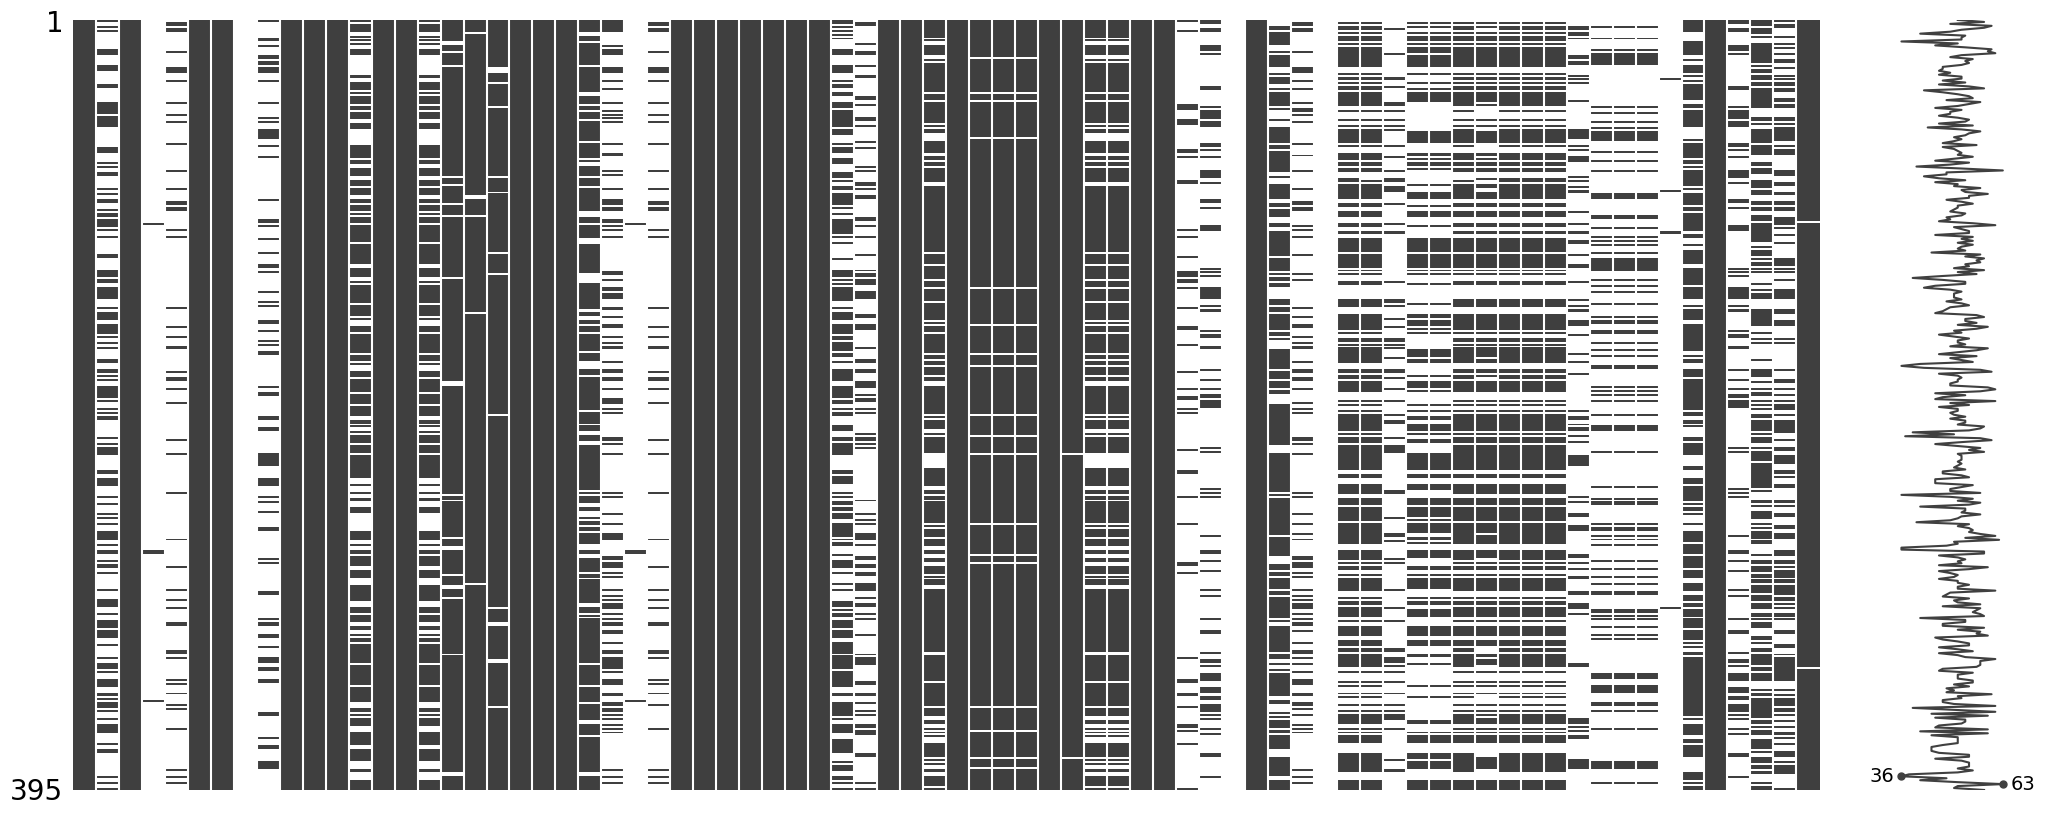

In [ ]:
msno.matrix(df_jobs)

#### Je vais regarder un peu différentes valeurs sur le type de contrat, les compétences, les outils

In [ ]:
# SKILLS
display(df_jobs["job.skills_clean"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

job.skills_clean
[Gestion de projets]                           7.9%
[Visualisation des données]                    5.6%
[Collecte et analyse de données]               5.6%
[Méthodologies Agile]                          5.1%
[Collaboration et travail d'équipe]            5.1%
[Analyse des données]                          5.1%
[Relations avec les salariés]                  4.5%
[Travail d'équipe]                             4.5%
[Rédaction technique]                          3.4%
[Recherche et analyse de données]              2.8%
[Souci du détail]                              2.8%
[Compétences en communication]                 2.2%
[Coaching et mentorat]                         2.2%
[Aptitude à animer des présentations]          2.2%
[Modélisation financière]                      1.7%
[Connaissance des protocoles de sécurité]      1.7%
[Responsabilité sociale des entreprises]       1.7%
[Sens de l’observation]                        1.7%
[Contrôle qualité]                             

In [ ]:
# TOOLS
display(df_jobs["job.tools_clean"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

job.tools_clean
[Tableau]             12.8%
[Excel]                6.6%
[Sql]                  6.2%
[Git]                  5.0%
[Alteryx]              4.1%
[Looker]               3.3%
[Java]                 3.3%
[Power bi]             2.9%
[Hadoop]               2.9%
[Oracle]               2.9%
[Nosql]                2.9%
[Kong]                 2.5%
[Dataiku]              2.5%
[Scala]                2.5%
[Azure]                2.5%
[Gitlab]               2.1%
[Adobe analytics]      2.1%
[Github]               2.1%
[Mysql]                1.7%
[Plotly]               1.7%
[Pycharm]              1.2%
[ net]                 1.2%
[Sap]                  1.2%
[Informatica]          1.2%
[Mixpanel]             1.2%
[Kubernetes]           1.2%
[Qlikview]             0.8%
[Python]               0.8%
[Shiny]                0.8%
[Metabase]             0.8%
[Business object]      0.8%
[Qliksense]            0.8%
[Foundation]           0.8%
[Segment]              0.8%
[Tensorflow]           0.4%
[Cen

In [ ]:
# SECTEURS
display(df_jobs["job.organization.sectors_clean"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

job.organization.sectors_clean
[IT / Digital, IT / Digital]                                                                20.3%
[Mobile Apps, Mobile Apps]                                                                  11.6%
[Artificial Intelligence / Machine Learning, Artificial Intelligence / Machine Learning]     8.6%
[Banking, Banking]                                                                           8.1%
[Digital Marketing / Data Marketing, Digital Marketing / Data Marketing]                     5.6%
[Software, Software]                                                                         4.6%
[Organization / Management, Organization / Management]                                       4.3%
[Strategy, Strategy]                                                                         4.1%
[Specialised Engineering, Specialised Engineering]                                           3.0%
[SaaS / Cloud Services, SaaS / Cloud Services]                                         

In [ ]:
# CONTRACTS
display(df_jobs["job.contract_type"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

job.contract_type
full_time    95.9%
temporary     4.1%
Name: proportion, dtype: object

In [ ]:
# REMOTE
display(df_jobs["job.remote"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

job.remote
partial     52.9%
no          30.4%
punctual    14.7%
fulltime     2.0%
Name: proportion, dtype: object

In [ ]:
# CITY
display(df_jobs["job.office.city"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

job.office.city
Paris                      47.3%
Lyon                        3.5%
Levallois-Perret            3.3%
Croix                       2.8%
Toulouse                    2.5%
Nanterre                    2.3%
Lille                       2.0%
Bordeaux                    2.0%
Puteaux                     2.0%
Aix-en-Provence             1.8%
Courbevoie                  1.8%
Nantes                      1.5%
Boulogne-Billancourt        1.5%
Neuilly-sur-Seine           1.5%
Clichy                      1.5%
Suresnes                    1.5%
La Défense                  1.3%
Mérignac                    1.0%
Rennes                      0.8%
Montpellier                 0.8%
Marseille                   0.8%
Châtillon                   0.5%
Limonest                    0.5%
Bois-Colombes               0.5%
Massy                       0.5%
Strasbourg                  0.5%
Malakoff                    0.5%
Villeurbanne                0.5%
Évry-Courcouronnes          0.5%
Gennevilliers              

In [ ]:
display(df_jobs["job.office.city"].value_counts())

job.office.city
Paris                      187
Lyon                        14
Levallois-Perret            13
Croix                       11
Toulouse                    10
Nanterre                     9
Lille                        8
Bordeaux                     8
Puteaux                      8
Aix-en-Provence              7
Courbevoie                   7
Nantes                       6
Boulogne-Billancourt         6
Neuilly-sur-Seine            6
Clichy                       6
Suresnes                     6
La Défense                   5
Mérignac                     4
Rennes                       3
Montpellier                  3
Marseille                    3
Châtillon                    2
Limonest                     2
Bois-Colombes                2
Massy                        2
Strasbourg                   2
Malakoff                     2
Villeurbanne                 2
Évry-Courcouronnes           2
Gennevilliers                2
Marcq-en-Baroeul             2
Pantin                 

----------------------------------------------------

ici des outils qui m'ont servi mais dont je n'ai plus besoin

In [ ]:
extract = list(df_job_temp["job.tools"])
print(extract)

NameError: name 'df_job_temp' is not defined

In [ ]:
extract = list(df_job_temp["job.tools"])
print(extract)

[[{'name': 'Nosql', 'reference': '463c82d3-9c2d-46ac-8f84-2332c4798f32'}, {'name': 'Sql', 'reference': 'e9255a1d-8071-4a44-a28c-a36d1b925178'}]]


In [ ]:
extract = list(df_job_temp["job.application_fields"])
print(extract)

[[{'id': '0e7960ee-b173-4aef-b52d-5c160fe82d22', 'mode': 'optional', 'name': 'cover_letter'}, {'id': '6789a3be-baf8-40d4-b963-fe1235e30bab', 'mode': 'mandatory', 'name': 'resume'}, {'id': 'd464e154-98ad-4d09-87ab-91411aea9fbf', 'mode': 'disabled', 'name': 'portfolio'}, {'id': '7d17fad8-6148-4a6d-ab97-ce41834fe5c6', 'mode': 'optional', 'name': 'picture'}, {'id': '89798d58-34c8-4116-a2f2-bdbe33a86402', 'mode': 'optional', 'name': 'media_website'}, {'id': 'e71d4049-ba42-433c-a899-ff91792f4ffd', 'mode': 'optional', 'name': 'media_linkedin'}, {'id': '5a96b1bc-1841-4aa0-9a59-12e244019fb7', 'mode': 'optional', 'name': 'media_twitter'}, {'id': '7483ddc3-6ec7-47ca-847d-d3f3f2de81a2', 'mode': 'disabled', 'name': 'media_github'}, {'id': '634f797a-dced-4108-b36a-18ba1f82bfe1', 'mode': 'disabled', 'name': 'media_stackoverflow'}, {'id': '3d5c7b20-b39e-4f13-8af3-172f2edcc0aa', 'mode': 'disabled', 'name': 'media_behance'}, {'id': 'c4807109-c7b0-45d9-9112-3dd8401b9d59', 'mode': 'disabled', 'name': 'med

Ci-dessous la poubelle

In [ ]:
## j'abonne la boucle while car il génère des pages vides ad vitam

## fonction selenium qui permet de récupérer l'url courante
# result_url = driver.current_url
# print("The current url is:"+str(result_url))
# # base_url = result_url.replace("1","")

base_url = "https://www.welcometothejungle.com/fr/jobs?query=data%20analyst&refinementList%5Boffices.country_code%5D%5B%5D=FR&refinementList%5Bcontract_type%5D%5B%5D=full_time&refinementList%5Bcontract_type%5D%5B%5D=temporary&page="
page_number = 1
urls_to_scrape = []

while True:
    url = f"{base_url}{page_number}"
    response = requests.get(url)
    if response.status_code == 200:
        print(f"Réponse 200 reçue ! - page :{page_number}")
        page_number += 1
        urls_to_scrape.append(url)
    else:
        print(f"Code de réponse : {response.status_code}. Sortie de la boucle.")
        break

In [ ]:
###code pour récupérer les pages - mais pas valide car href est vide et généré de manière dynamique
# random_delay() 

# je récupère le code HTML de la page avec Selenium
page_source = driver.page_source

#  je passe le code HTML à BeautifulSoup pour l'analyser
soup = BeautifulSoup(page_source, "html.parser")

# Nous filtrons maintenant uniquement sur les acteurs et actrices :
soup_pages = soup.find('nav', {"aria-label" : "Pagination"})


if soup_pages is not None:
# Puis nous cherchons tous les liens contenus dans cet encadré :
    plinks = soup_pages.find_all('a')

# pages = driver.find_elements(By.CLASS_NAME, "sc-dUYLmH")                 # toujours avec Selenium, je cherche les liens ds l'ul sc-cDvQBt eCFBkT
# pages_links = [plink.get_attribute("href") for plink in pages]           # j'extraits le contenu de href pour le mettre dans la liste urls

    print(plinks)

else:
    print("Aucun élément HTML correspondant au sélecteur spécifié n'a été trouvé.")

In [ ]:
## je fais une fonction

def urls_extractor(urlss):
    
    if driver.status_code == 200:
        links = driver.find_elements(By.PARTIAL_LINK_TEXT, "Data")          # toujours avec Selenium, je cherche les liens avec data dedans
        urls = [link.get_attribute("href") for link in links]               # j'extraits le contenu de href pour le mettre dans la liste urls
        return(urls)

    else:
        print(f"Erreur lors de la récupération de la page {url}.")

In [ ]:
base_url = "https://www.welcometothejungle.com/fr/jobs?refinementList%5Boffices.country_code%5D%5B%5D=FR&query=data%20analyst&page="
page_number = 1
urls_to_scrape = []

while True:
    url = f"{base_url}{page_number}"
    response = requests.get(url)
    if response.status_code == 200:
        print(f"Réponse 200 reçue ! - page :{page_number}")
        page_number += 1
        urls_to_scrape.append(url)
    else:
        print(f"Code de réponse : {response.status_code}. Sortie de la boucle.")
        break


   



In [ ]:
### ajouter un delay
def random_delay():
    time.sleep(random.uniform(2, 5))

### enlever les baslises html
def remove_html_tags(text_col):
    if text_col is None:
        return None
    else:
        clean = re.compile('<.*?>')
        return re.sub(clean,"", text_col)

### décompacter les tools
def jtools_extractor(col):
    tools = []                                      # je crée un liste pour stocker mes outils
    for dicos in (df_jobs_temp["job.tools"][0]):     # je vais chercher chaque dico contenu dans le premier (et seul) item de ma liste de cette colonne
        for key, tool in dicos.items():             # dans le duo key/value de mes items de chaque dico
            if key == "name":                       # si la clé est = à name
                tools.append(dicos["name"])         # alors je stocke cet outil dans une liste
    # return ", ".join(tools)                       # attention à bien remonter return en dehors de la deuxième boucle for
    return(tools)

### décompacter les skills
def jskills_extractor(col):
    skills = []                                         # je crée un liste pour stocker mes skills
    for dictos in (df_jobs_temp["job.skills"][0]):      # je vais chercher chaque dico contenu dans le premier item de ma liste de cette colonne
        for key, value in dictos.items():               # dans le duo key/value de mes items de chaque dico
            if key == "name":                           # je vais chercher l'item name
               for sec_key, skill in value.items():     # cet item étant un dict. je cherche la paire k/v
                   if sec_key == "fr":                  # si la clé est = à "fr"
                         skills.append(skill)           # alors je stocke cette skill dans une liste
    return(skills)

### récupérer ce qui est obligatoire pour la candidature

def appli_mandatory_extractor(col):
    applications = []                                           # je crée un liste pour stocker mes éléments mandatory
    for dicts in (df_jobs_temp["job.application_fields"][0]):   # je vais chercher chaque dico contenu dans le premier (et seul) item de ma liste de cette colonne
            for key, value in dicts.items():                    # dans le duo key/value de mes items de chaque dico
                if value == "mandatory":                        # si une value est = à mandatory
                    applications.append(dicts["name"])          # alors je stocke chaque clé correspondante à name
    return(applications)